In [ ]:
ls

sample_data/


In [ ]:
!mkdir .kaggle

import json
token = {"username":"______________________","key":"______________________"}
with open('/content/.kaggle/kaggle.json','w') as file:
    json.dump(token,file)

!mkdir ~/.kaggle

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

!kaggle competitions download -c dogs-vs-cats -p/content

!unzip -q test1.zip -d .
!unzip -q train.zip -d .

- path is now set to: {/content}
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 32.4MB/s]
 97% 262M/271M [00:01<00:00, 140MB/s]
100% 271M/271M [00:01<00:00, 144MB/s]
 98% 533M/543M [00:03<00:00, 188MB/s]
100% 543M/543M [00:03<00:00, 157MB/s]


In [ ]:
ls

sample_data/  sampleSubmission.csv  test1/  test1.zip  train/  train.zip


In [ ]:
import os
import pandas as pd

filenames = os.listdir('/content/train/')
categories = []

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df.category = df.category.map(
    {
        0: '0',
        1: '1'
    }
)

df.head()

,filename,category
0,cat.2114.jpg,0
1,cat.6159.jpg,0
2,dog.10934.jpg,1
3,cat.10.jpg,0
4,dog.10225.jpg,1


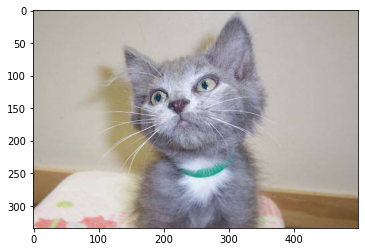

In [ ]:
from matplotlib import pyplot as plt
from keras.preprocessing.image import load_img
import random

sample = random.choice(filenames)
image = load_img("/content/train/"+sample)
plt.imshow(image)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)


train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/train/", 
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

Found 20000 validated image filenames belonging to 2 classes.


In [ ]:
train_df

,filename,category
0,dog.4413.jpg,1
1,cat.11742.jpg,0
2,dog.610.jpg,1
3,cat.5334.jpg,0
4,dog.5827.jpg,1
...,...,...
19995,cat.6813.jpg,0
19996,cat.8574.jpg,0
19997,cat.11273.jpg,0
19998,dog.7372.jpg,1


In [ ]:
validate_df

,filename,category
0,cat.124.jpg,0
1,cat.2769.jpg,0
2,cat.7056.jpg,0
3,dog.3006.jpg,1
4,cat.2485.jpg,0
...,...,...
4995,cat.9567.jpg,0
4996,cat.4383.jpg,0
4997,cat.1189.jpg,0
4998,dog.6772.jpg,1


In [ ]:
validation_datagen = ImageDataGenerator(
    rescale=1./255,
)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/train/", 
    x_col='filename',
    y_col='category',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32
)

Found 5000 validated image filenames belonging to 2 classes.


In [ ]:
def check(t):
  if t[0] == 1:
    return "Cat"
  
  return "Dog"

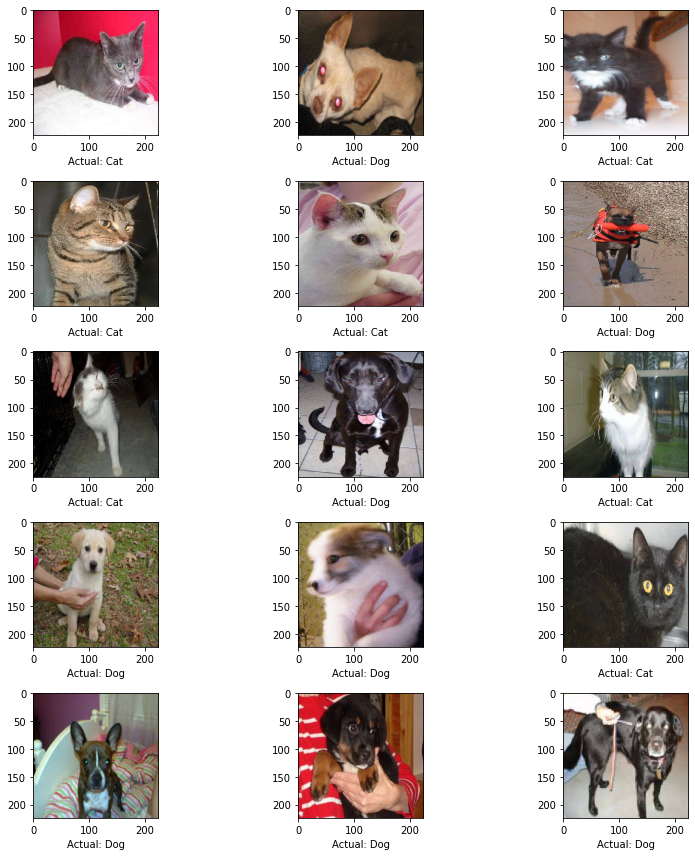

In [ ]:
plt.figure(figsize=(12, 12))

for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in validation_generator:
        image = X_batch[0]
        plt.xlabel("Actual: " + check(Y_batch[0]))
        plt.imshow(image)
        break

plt.tight_layout()
plt.show()

In [ ]:
from keras.models import Sequential
from keras.regularizers import l2
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(64, kernel_size=5, kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=3, strides=2, kernel_initializer='he_uniform'))
model.add(Activation('elu'))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(64, kernel_size=3, kernel_initializer='he_uniform', padding='same'))
model.add(Activation('elu'))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=5, strides=2, kernel_initializer='he_uniform', padding='same'))
model.add(Activation('elu'))
model.add(MaxPooling2D(2, 2))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(756, kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(256, kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(2, kernel_initializer='he_uniform'))
model.add(Activation('sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      4864      
_________________________________________________________________
activation (Activation)      (None, 224, 224, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 64)      256       
_________________________________________________________________
dropout (Dropout)            (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 111, 111, 128)     73856     
_________________________________________________________________
activation_1 (Activation)    (None, 111, 111, 128)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 128)       0

In [ ]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator, 
    epochs=15,
    validation_data=validation_generator,
)

Epoch 1/15
625/625 [==============================] - 283s 452ms/step - loss: 0.7165 - accuracy: 0.6342 - val_loss: 0.5747 - val_accuracy: 0.7012
Epoch 2/15
625/625 [==============================] - 284s 454ms/step - loss: 0.5540 - accuracy: 0.7243 - val_loss: 0.4845 - val_accuracy: 0.7704
Epoch 3/15
625/625 [==============================] - 285s 456ms/step - loss: 0.4880 - accuracy: 0.7668 - val_loss: 0.4293 - val_accuracy: 0.8116
Epoch 4/15
625/625 [==============================] - 284s 455ms/step - loss: 0.4469 - accuracy: 0.7928 - val_loss: 0.3858 - val_accuracy: 0.8274
Epoch 5/15
625/625 [==============================] - 282s 452ms/step - loss: 0.4203 - accuracy: 0.8081 - val_loss: 0.4138 - val_accuracy: 0.8088
Epoch 6/15
625/625 [==============================] - 283s 452ms/step - loss: 0.3865 - accuracy: 0.8266 - val_loss: 0.3521 - val_accuracy: 0.8416
Epoch 7/15
625/625 [==============================] - 284s 454ms/step - loss: 0.3495 - accuracy: 0.8447 - val_loss: 0.3029 -

accuracy: 91.24%


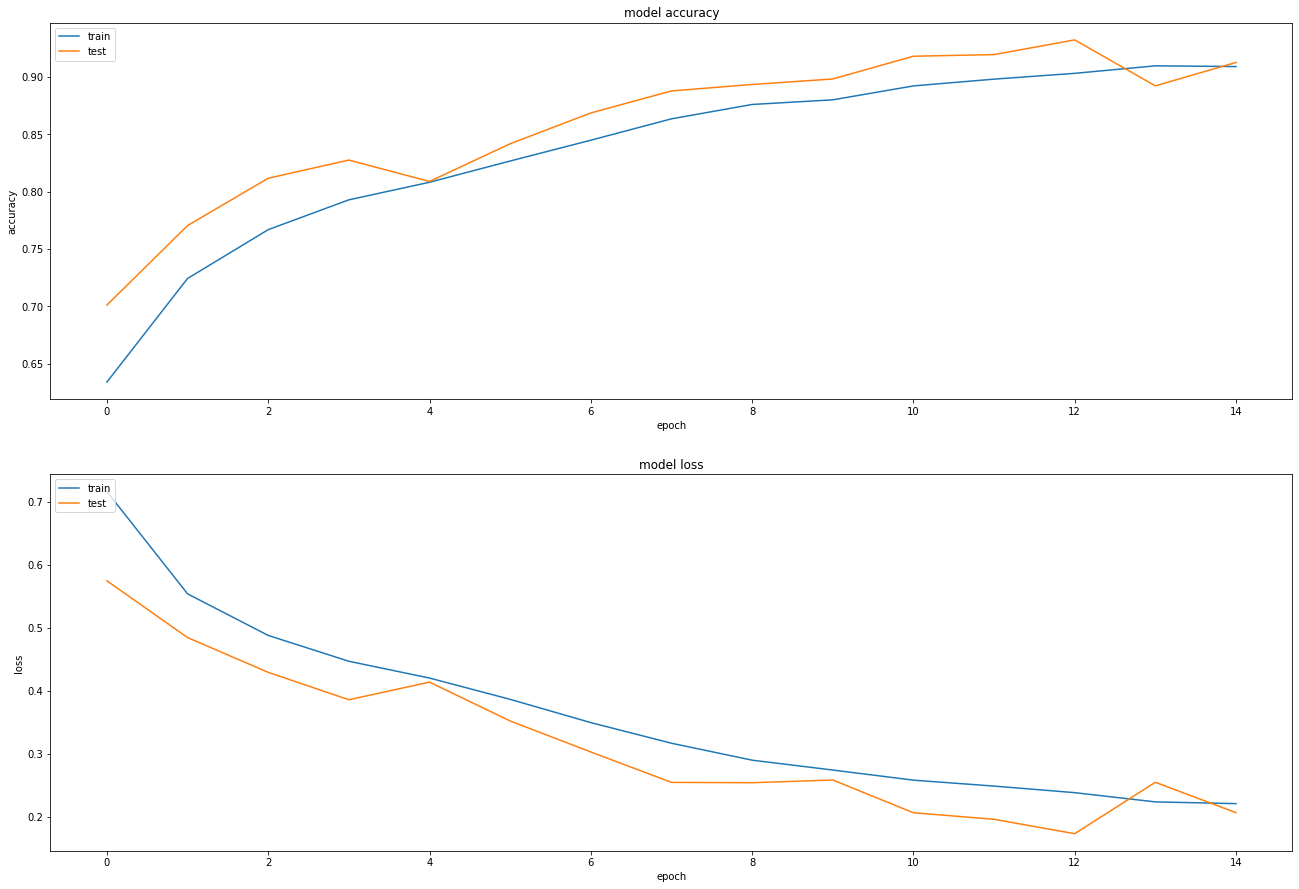

In [ ]:
score = model.evaluate(validation_generator, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
  
# summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

plt.subplots_adjust(right=3, top=3)
plt.show()

In [ ]:
history = model.fit(
    train_generator, 
    epochs=15,
    validation_data=validation_generator,
)

Epoch 1/15
625/625 [==============================] - 281s 450ms/step - loss: 0.2158 - accuracy: 0.9128 - val_loss: 0.1779 - val_accuracy: 0.9252
Epoch 2/15
625/625 [==============================] - 283s 453ms/step - loss: 0.2122 - accuracy: 0.9142 - val_loss: 0.1589 - val_accuracy: 0.9368
Epoch 3/15
625/625 [==============================] - 282s 451ms/step - loss: 0.2039 - accuracy: 0.9147 - val_loss: 0.1799 - val_accuracy: 0.9266
Epoch 4/15
625/625 [==============================] - 283s 453ms/step - loss: 0.1982 - accuracy: 0.9180 - val_loss: 0.1644 - val_accuracy: 0.9342
Epoch 5/15
625/625 [==============================] - 283s 453ms/step - loss: 0.1893 - accuracy: 0.9227 - val_loss: 0.1580 - val_accuracy: 0.9370
Epoch 6/15
625/625 [==============================] - 282s 452ms/step - loss: 0.1900 - accuracy: 0.9237 - val_loss: 0.1568 - val_accuracy: 0.9366
Epoch 7/15
625/625 [==============================] - 282s 451ms/step - loss: 0.1861 - accuracy: 0.9245 - val_loss: 0.1553 -

accuracy: 95.42%


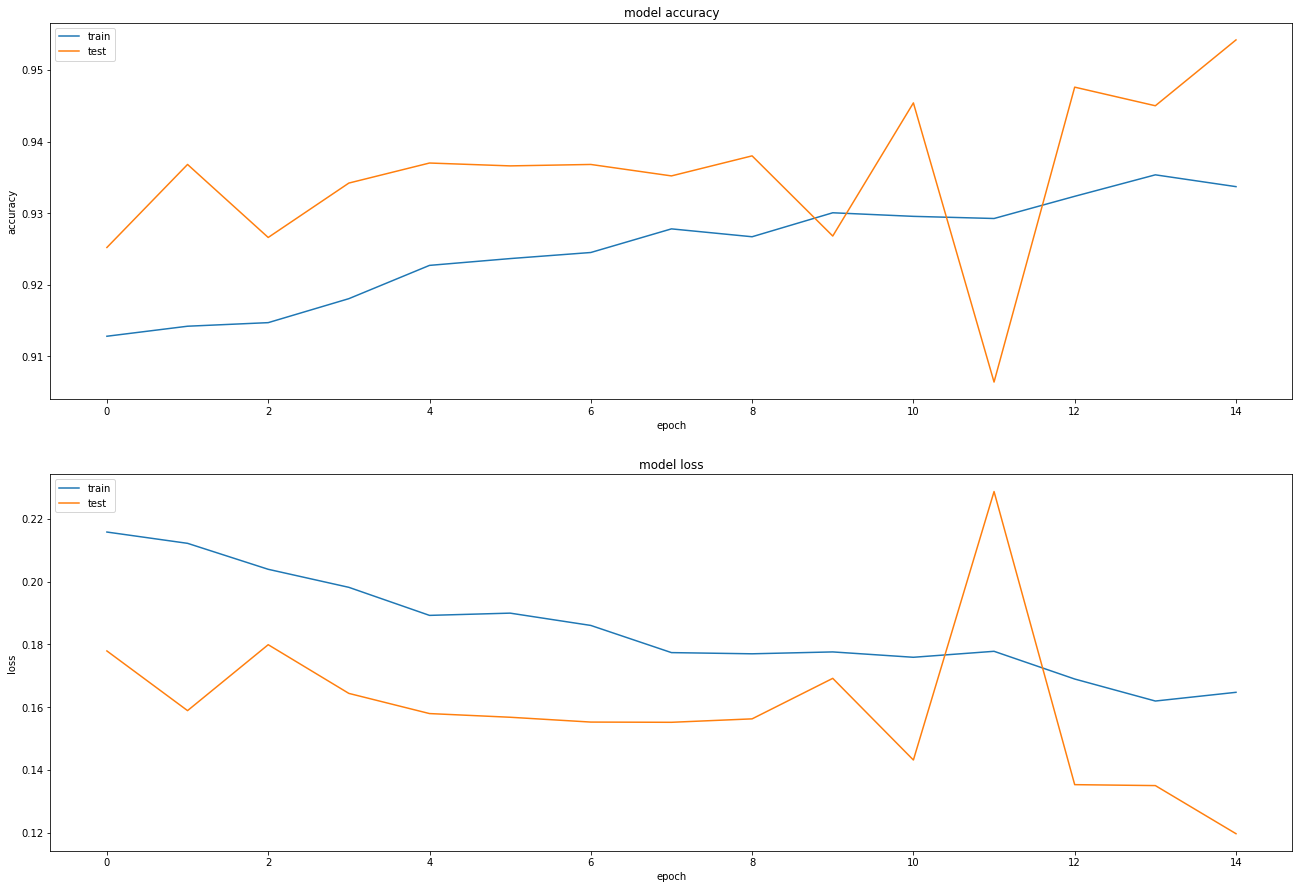

In [ ]:
score = model.evaluate(validation_generator, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
  
# summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

plt.subplots_adjust(right=3, top=3)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AH9XCy3ZxvtweJuRnh44t-aCI6TWDV1O0ELYmdkvPHL9RO1t-WJrjo
Mounted at /content/gdrive


In [ ]:
ls

gdrive/       sampleSubmission.csv  test1.zip  train.zip
sample_data/  test1/                train/


In [ ]:
cd gdrive/My\ Drive/Temp/Cats\ vs\ Dogs

/content/gdrive/My Drive/Temp/Cats vs Dogs


In [ ]:
model.save('final.h5')

In [ ]:
ls

catsvsdogs_10epochs_92.h5    final.h5  model.json
catsvsdogs_25epochs_94-6.h5  model.h5


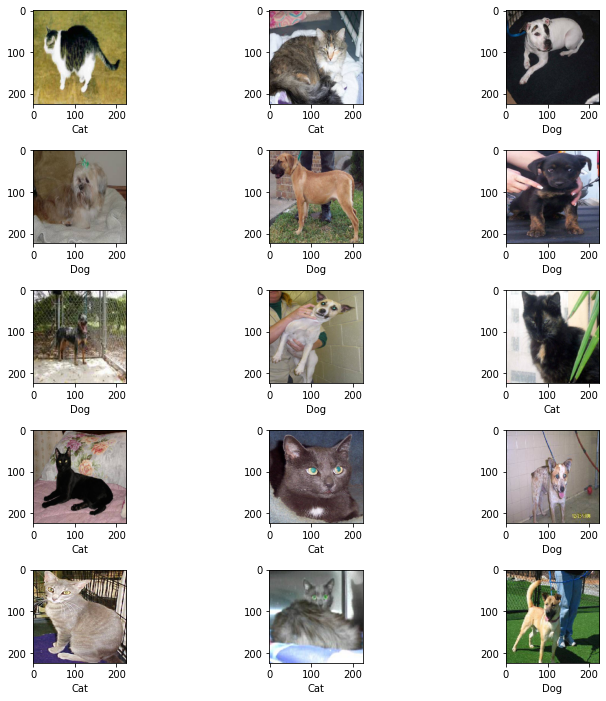

In [ ]:
import pandas as pd
import numpy as np

val_image_batch, val_label_batch = next(iter(validation_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

pred = model.predict(val_image_batch)
pred_df = pd.DataFrame(pred)
pred_df.columns = [1, 0]
pred_ids = np.argmax(pred, axis=-1)


plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=0.5)
for n in range(15):
  plt.subplot(5, 3, n+1)
  plt.imshow(val_image_batch[n])

  plt.xlabel("Cat" if pred_ids[n] == 0 else "Dog")